In [28]:
import os
import math
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from pandas.plotting import scatter_matrix

In [29]:
# function for plotting learning curves (https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [30]:
# Reading in the data
train_csv = pd.read_csv("train_.csv")

# for my validation
# train_csv = pd.read_csv("train_anirudha_train.csv")

# shuffling the data - just to make sure
train_csv = train_csv.sample(frac=1).reset_index(drop=True)

train_csv_dims = train_csv.shape
print("Shape of the train csv file is: ", train_csv_dims)

# Check which cols are numeric/ categorical
cols = train_csv.columns # all cols
num_cols = train_csv._get_numeric_data().columns # only numeric cols

print("Number of numeric cols: ", len(num_cols))
print("Number of categorical cols: ", len(list(set(cols) - set(num_cols))))
print("Categorical columns are: ", list(set(cols) - set(num_cols)))

Shape of the train csv file is:  (8000, 101)
Number of numeric cols:  98
Number of categorical cols:  3
Categorical columns are:  ['x13', 'x68', 'x91']


In [31]:
for col in train_csv:
    if len(train_csv[col].unique()) < 7500:
        print(col, len(train_csv[col].unique()))
        # verifies that x13, x68 and x91 are indeed the only categorical values

x13 4
x68 13
x91 6


In [32]:
# not much you can infer from this distribution below; without knowing domain - also, this is dummy data 
print(train_csv['x13'].value_counts())
print(train_csv['x68'].value_counts())
print(train_csv['x91'].value_counts())

B    6052
C    1086
A     860
Name: x13, dtype: int64
J    1769
F    1742
H    1306
E    1304
D     639
s     604
o     255
C     246
B      65
n      54
A       8
d       7
Name: x68, dtype: int64
W    4474
H    1728
T    1631
M      84
F      81
Name: x91, dtype: int64


In [33]:
inds = pd.isnull(train_csv).any(1).nonzero()[0]
print("Number of rows in which NaNs are present: ", len(inds)) 

# there are only 73/8000 rows where nans are present; better to remove them since 73 is a small portion and also because I do not have domain knowledge
# else, I could have tried imputation techniques. For now, best to remove them so that the model that is developed is generalizable as well.

Number of rows in which NaNs are present:  73


In [34]:
# preprocessing training data

train_csv.dropna(inplace=True)

# we need to check for outliers in the data for each column
# let us keep the categorical columns separate and work on the numeric data
cat_train_csv = pd.concat([train_csv['x13'], train_csv['x68'], train_csv['x91']], axis=1)
cat_train_csv.reset_index(inplace=True, drop=True)
label_train_csv = train_csv['y']
train_csv.drop(['x13', 'x68', 'x91'], axis=1, inplace=True)

Features which are most correlated with target:  ['x25', 'x80', 'x76', 'x5']
Their corresponding abs. correlation values:  [0.8015828789562396, 0.6382630752337054, 0.6056132061305955, 0.6027281477873715, 0.5754962925793801, 0.5709143295586728, 0.5680897866174552, 0.5476694865239009, 0.5446670112121187]


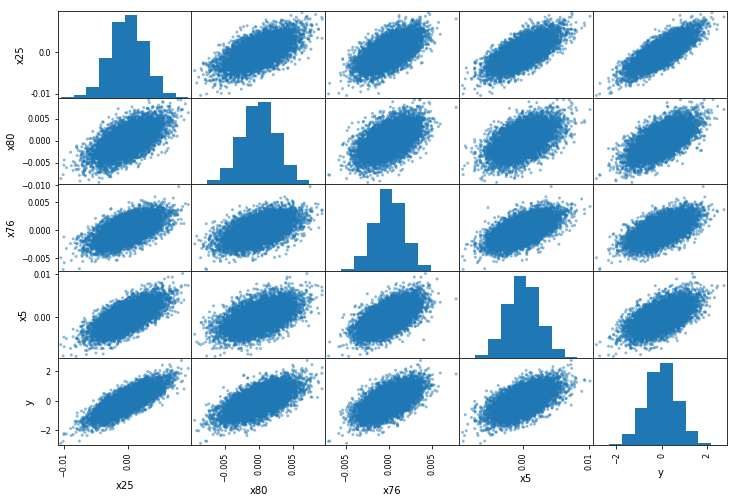

In [35]:
# Explore correlations between features and target
x = train_csv[train_csv.columns[1:]].corr()['y'][:]
inds = x.index.tolist()
vals = x.tolist()
attrs = sorted(inds, key=lambda x: vals[inds.index(x)])[-5:][::-1][1:]
print("Features which are most correlated with target: ", attrs)
print("Their corresponding abs. correlation values: ", sorted(vals, reverse=True)[1:10])
scatter_matrix(train_csv[attrs+['y']], figsize=(12,8))
plt.show()

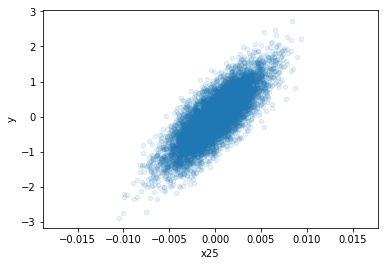

In [36]:
train_csv.plot(kind='scatter', x='x25', y='y', alpha=0.1) # pick out strongest correlation data and plot
plt.show() # shows very strong correlation; most of data in the center.

In [37]:
# y = train_csv[train_csv.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)] # we can do this to check for outliers since this is now scaled data (looks like a lot of outliers)
# removing outliers from the data is questionable, so I will leave it as it is.
train_csv.drop(['y'], axis=1, inplace=True)

x8   x17    0.790071
x37  x97    0.758676
x35  x71    0.758345
x19  x98    0.740033
x12  x98    0.739817
x28  x42    0.728771
x17  x49    0.720653
x19  x75    0.720449
     x97    0.720068
x3   x85    0.713011
x69  x93    0.708264
x18  x84    0.705986
x33  x37    0.705569
x37  x65    0.705451
x24  x25    0.704822
x6   x98    0.699926
x36  x90    0.694864
x5   x25    0.693899
x0   x85    0.690887
x3   x92    0.684749
dtype: float64


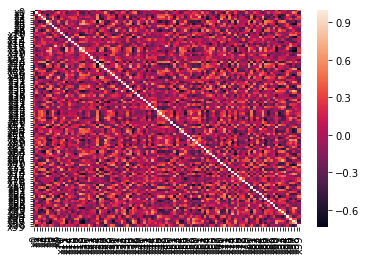

In [38]:
# Explore correlations between features
corr = train_csv.corr()

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

# print("Top Absolute Correlations")
corr_stats = get_top_abs_correlations(train_csv, 20) # print(corr_stats) - to see which all features are correlated with one another the most
print(corr_stats)

# looks like 'x25' is most correlated with y and there are some features that are correlated with one another.

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show() # - a bit dense, not much information can be gained; there are some highly correlated variables; will need PCA fit_transform.

In [39]:
# main preprocessing before building model
# let us scale data in all columns; regression anyway requires scaled data; RF does not require scaling. PCA must be done only after scaling
scaler = StandardScaler()
train_csv[train_csv.columns] = scaler.fit_transform(train_csv[train_csv.columns])
pca = PCA(n_components=0.99, svd_solver='full') # make sure we have > 95% variance explained when we transform
train_csv_transformed = pca.fit_transform(train_csv)
# plt.scatter(train_csv_transformed[0], train_csv_transformed[1])
# plt.show()
# print(pca.explained_variance_)
dummy_train = pd.get_dummies(data=cat_train_csv, drop_first=True)

### Training phase
# final mx for training
train_csv_final = pd.concat([pd.DataFrame(train_csv_transformed), dummy_train], axis=1)


In [ ]:

print("Training scores: ")

# trying KNNregressor since once reduced, there are only ~45 dims
cv_scores = []
neighbors = [x for x in range(1,25) if x%2!=0]
for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, train_csv_final, label_train_csv, cv=10, scoring=make_scorer(mean_squared_error))
    cv_scores.append(math.sqrt(scores.mean())) # appending with RMSE means
    # cv_scores.append(scores.mean())
optimal_k = neighbors[cv_scores.index(min(cv_scores))]
print("The optimal number of neighbors is: ", optimal_k)
# plot misclassification error vs k
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('RMSE KNNRegressor')
plt.show()
# refit with optimal_k
refit = KNeighborsRegressor(n_neighbors=optimal_k)
title="Learning Curves (KNeighborsRegressor)"
plot_learning_curve(refit, title, train_csv_final, label_train_csv, ylim=(0.6, 0.8), cv=10, n_jobs=4)
plt.show()
refit = refit.fit(train_csv_final, label_train_csv)
print("KNeighborsRegressor R^2 score: ", refit.score(train_csv_final, label_train_csv))
print("KNeighborsRegressor RMSE score: ", math.sqrt(mean_squared_error(refit.predict(train_csv_final), label_train_csv)))

Training scores: 


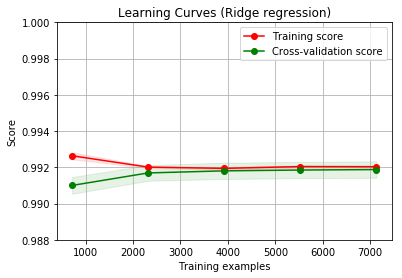

Ridge R^2 score:  0.9920260006229941
Ridge RMSE score:  0.06241674128355277


In [49]:
# trying Ridge because we need regularization to prevent overfitting
ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 5.5, 6, 6.5, 7, 8, 9, 10])
title="Learning Curves (Ridge regression)"
plot_learning_curve(ridge, title, train_csv_final, label_train_csv, ylim=(0.988, 1.0), cv=10, n_jobs=4)
plt.show()
ridge.fit(train_csv_final, label_train_csv)
# print("Estimated regularization parameter: ", ridge.alpha_)
# print("Weight vectors:", ridge.coef_)
print("Ridge R^2 score: ", ridge.score(train_csv_final, label_train_csv))
print("Ridge RMSE score: ", math.sqrt(mean_squared_error(ridge.predict(train_csv_final), label_train_csv)))

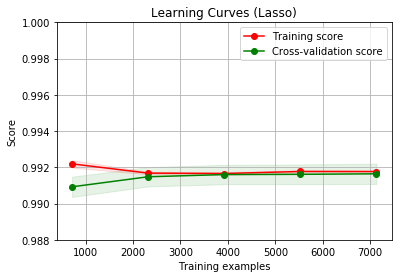

Lasso R^2 score:  0.9917626552128418
Lasso RMSE score:  0.06343904175636474


In [48]:
# trying Lasso because we know some features need to be removed
lasso = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 5.5, 6, 6.5, 7, 8, 9, 10])
title="Learning Curves (Lasso)"
plot_learning_curve(lasso, title, train_csv_final, label_train_csv, ylim=(0.988, 1.0), cv=10, n_jobs=4)
plt.show()
lasso.fit(train_csv_final, label_train_csv)
# print("Estimated regularization parameter: ", lasso.alpha_)
# print("Weight vectors:", lasso.coef_)
print("Lasso R^2 score: ", lasso.score(train_csv_final, label_train_csv))
print("Lasso RMSE score: ", math.sqrt(mean_squared_error(lasso.predict(train_csv_final), label_train_csv)))

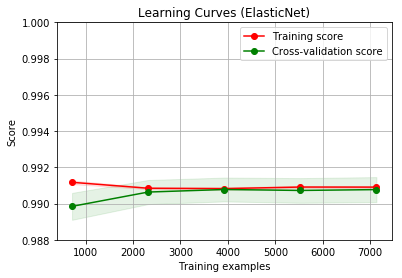

ElasticNet R^2 score:  0.9909024729349817
ElasticNet RMSE score:  0.06666911195448876


In [47]:
# trying elastic net regression since there is correlation between features. We might not want to fully get rid of transformed PCA features
regr = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .9, .95, .99, 1], cv=10, tol=0.00001)
title="Learning Curves (ElasticNet)"
plot_learning_curve(regr, title, train_csv_final, label_train_csv, ylim=(0.988, 1.0), cv=10, n_jobs=4)
plt.show()
regr.fit(train_csv_final, label_train_csv)
# print("ElasticNetCV results")
# print("Coefficients are: ", regr.coef_)
# print("MSE path", regr.mse_path_)
# print("Number of iters: ", regr.n_iter_)
print("ElasticNet R^2 score: ", regr.score(train_csv_final, label_train_csv))
print("ElasticNet RMSE score: ", math.sqrt(mean_squared_error(regr.predict(train_csv_final), label_train_csv)))

In [44]:
# trying MLP to fit the non-linearity - bonus model
mlp_regr = MLPRegressor(hidden_layer_sizes=(10, 2))
# title="Learning Curves (KNeighborsRegressor)"
# plot_learning_curve(mlp_regr, title, train_csv_final, label_train_csv, ylim=(0.0, 1.01), cv=10, n_jobs=4)
# plt.show()
mlp_regr.fit(train_csv_final, label_train_csv)
# print("Loss: ", mlp_regr.loss_)
# print("Weight mx: ", mlp_regr.coefs_)
print("MLP R^2 score: ", mlp_regr.score(train_csv_final, label_train_csv))
print("MLPRegressor RMSE score: ", math.sqrt(mean_squared_error(mlp_regr.predict(train_csv_final), label_train_csv)))
print()

MLP R^2 score:  0.9880440371852656
MLPRegressor RMSE score:  0.07642848835510178



In [45]:
'''
### Validation phase (to be commented out when finalizing model - this phase used only for tuning)
valid_csv = pd.read_csv("train_anirudha_val.csv")
valid_csv.dropna(inplace=True)
valid_labels = valid_csv['y']
cat_valid_csv = pd.concat([valid_csv['x13'], valid_csv['x68'], valid_csv['x91']], axis=1)
cat_valid_csv.reset_index(inplace=True, drop=True)
valid_csv.drop(['x13', 'x68', 'x91', 'y'], axis=1, inplace=True)

# preprocessing validation data sccording to the training data
valid_csv[valid_csv.columns] = scaler.transform(valid_csv[valid_csv.columns])
valid_csv_transformed = pca.transform(valid_csv)

dummy_valid = pd.get_dummies(data=cat_valid_csv, drop_first=True)
valid_csv_final = pd.concat([pd.DataFrame(valid_csv_transformed), dummy_valid], axis=1)

print("Validation scores: ")
print("KNeighborsRegressor R^2 score: ", refit.score(valid_csv_final, valid_labels))
print("KNeighborsRegressor RMSE score: ", math.sqrt(mean_squared_error(refit.predict(valid_csv_final), valid_labels)))
print("Ridge R^2 score: ", ridge.score(valid_csv_final, valid_labels))
print("Ridge RMSE score: ", math.sqrt(mean_squared_error(ridge.predict(valid_csv_final), valid_labels)))
print("Lasso R^2 score: ", lasso.score(valid_csv_final, valid_labels))
print("Lasso RMSE score: ", math.sqrt(mean_squared_error(lasso.predict(valid_csv_final), valid_labels)))
print("ElasticNet R^2 score: ", regr.score(valid_csv_final, valid_labels))
print("ElasticNet RMSE score: ", math.sqrt(mean_squared_error(regr.predict(valid_csv_final), valid_labels)))
print("MLP R^2 score: ", mlp_regr.score(valid_csv_final, valid_labels))
print("MLPRegressor RMSE score: ", math.sqrt(mean_squared_error(mlp_regr.predict(valid_csv_final), valid_labels)))
print()
'''


'\n### Validation phase (to be commented out when finalizing model - this phase used only for tuning)\nvalid_csv = pd.read_csv("train_anirudha_val.csv")\nvalid_csv.dropna(inplace=True)\nvalid_labels = valid_csv[\'y\']\ncat_valid_csv = pd.concat([valid_csv[\'x13\'], valid_csv[\'x68\'], valid_csv[\'x91\']], axis=1)\ncat_valid_csv.reset_index(inplace=True, drop=True)\nvalid_csv.drop([\'x13\', \'x68\', \'x91\', \'y\'], axis=1, inplace=True)\n\n# preprocessing validation data sccording to the training data\nvalid_csv[valid_csv.columns] = scaler.transform(valid_csv[valid_csv.columns])\nvalid_csv_transformed = pca.transform(valid_csv)\n\ndummy_valid = pd.get_dummies(data=cat_valid_csv, drop_first=True)\nvalid_csv_final = pd.concat([pd.DataFrame(valid_csv_transformed), dummy_valid], axis=1)\n\nprint("Validation scores: ")\nprint("KNeighborsRegressor R^2 score: ", refit.score(valid_csv_final, valid_labels))\nprint("KNeighborsRegressor RMSE score: ", math.sqrt(mean_squared_error(refit.predict(va

In [46]:

### Testing phase (to be used for final submission)
test_csv = pd.read_csv("test_.csv")
'''
# none of the categoricals are missing, I guess it is safe to impute with mean for the other missing rows
>>> test_csv = pd.read_csv("test_.csv")
>>> test_csv.count()['x13']
2000
>>> test_csv.count()['x68']
2000
>>> test_csv.count()['x91']
2000
'''
# preprocessing test data according to the training set
test_csv.fillna(test_csv.mean(), inplace=True) # imputing for test data only - not imputing for train since not many rows with NaNs.
cat_test_csv = pd.concat([test_csv['x13'], test_csv['x68'], test_csv['x91']], axis=1)
cat_test_csv.reset_index(inplace=True, drop=True)
test_csv.drop(['x13', 'x68', 'x91'], axis=1, inplace=True)
test_csv[test_csv.columns] = scaler.transform(test_csv[test_csv.columns])
test_csv_transformed = pca.transform(test_csv)

dummy_test = pd.get_dummies(data=cat_test_csv, drop_first=True)
test_csv_final = pd.concat([pd.DataFrame(test_csv_transformed), dummy_test], axis=1)

def print_to_csv(name, preds):
    new_path = os.getcwd() + '/' + name + '.csv'
    with open(new_path, 'w') as fp:
        for i in preds:
            fp.write(str(i))
            fp.write('\n')

print("Storing test results. ")
# print("KNeighborsRegressor results: ", refit.predict(test_csv_final))
print_to_csv('KNeighborsRegressor', refit.predict(test_csv_final))
# print("Ridge results: ", ridge.predict(test_csv_final))
print_to_csv('Ridge', ridge.predict(test_csv_final))
# print("Lasso results: ", lasso.predict(test_csv_final))
print_to_csv('Lasso', lasso.predict(test_csv_final))
# print("ElasticNet results: ", regr.predict(test_csv_final))
print_to_csv('ElasticNet', regr.predict(test_csv_final))
# print("MLP results: ", mlp_regr.predict(test_csv_final))
print_to_csv('MLP', mlp_regr.predict(test_csv_final))


Storing test results. 
